---
---

# PROBLEM DEFINITION

### GIVEN

- Lenard-Jones fluid consisting of 108 atoms of Argon.

- Initial reduced temperature: $T^* = \frac{k_B T}{\varepsilon} = 0.728$

- Reduced density: $ \rho^* = \rho \sigma^3 = 0.8442$

- Assume NVE ensemble

### FIND:

- Write a python program to perform molecular dynamics simulation:

   1) Write  a function  that initializes the  system (select initial  positions and  velocities for  the  chosen temperature and preserve zero total momentum)
   
   2) Write a function that calculates the forces on all particles.
   
   3) Write a function that performs either the position or velocity Verlet algorithm.
   
   4) Use the velocity autocorrelation function to calculate the diffusion coefficient.
   
   5) Run your NVE MD simulation and plot the total energy, the potential energy, and the kinetic energy per particle as a function of the number of time steps. Also plot the system temperature. Take different number time steps, i.e.: 0, 1000, 2000, etc.(take a look at Figure 4.3 on page 99 from Frenkel's textbook). Discuss your plot

---
---

# GOVERNING EQUATIONS

### Lenard-Jones Potential (reduced units)

$U(r) =  4 \left[\frac{1}{r^{12}} - \frac{1}{r^6}\right]$

### Lenard-Jones Force (reduced units)

$F_x (r) = - \frac{\partial U(r)}{\partial x} = - \frac{\partial r}{\partial x} \frac{\partial U (r)}{\partial r}= \frac{48x}{r^2}\left[\frac{1}{r^{12}} - \frac{0.5}{r^{6}}\right]$

### Velocity Verlet Algorithm

- position: $r(t + \Delta t) = r(t) + v(t)\Delta t + \frac{f(t)}{2m} \Delta t^2$

- velocity: $v(t + \Delta t) = v(t) + \frac{f(t) + f(t + \Delta t)}{2m} \Delta t$

- Note m = 1 when working in reduced variables

### Reduced Variables

- Length: $r^* = \frac{r}{\sigma}$

- Energy: $ E^* = \frac{E}{\varepsilon}$

- Mass:   $ m^* = \frac{m}{m}$

- Time:   $ t^* = \frac{t}{\sigma \sqrt{\frac{m}{\varepsilon}}} $

- Force:  $f^* = f \frac{\sigma}{\varepsilon}$

- Temperature: $T^* = T \frac{k_B}{\varepsilon}$

- Velocity: $v^* = v \sqrt{\frac{m}{\varepsilon}}$

- Diffusion Coefficient: $D^* = D \frac{t}{\sigma^2}$

### Reduced Kinetic Energy

 - Definition of Reduced Kinetic Energy
 
   - $KE^* = \frac{KE}{\varepsilon} = \frac{0.5 m v^2}{\varepsilon}$

 - Squaring both sides of reduced velocity:
 
    - $v^{*2} = \frac{mv^2}{\varepsilon}$
 
 - Multipyling both sides by 0.5:
  
    - $ 0.5 v^{*2} = \frac{0.5 mv^2}{\varepsilon} $
    
    - $ 0.5 v^{*2} = KE^* $
    
 - Therefore:
 
    - $ KE^* = 0.5 v^{*2}$

### Diffusion Coefficient

 - Green-Kubo relation for 3-D many-body diffusion coefficient
 
   - $ D_{PCB} = \frac{1}{3N} \sum_{i=1}^N \int_0^{\infty} d \tau <v_i(\tau) . v_i(0)>$
   
   
 - Correction for the effect of periodic boundary (Yeh & Hummer, 2004)
 
   - $ D = D_{PCB} + \frac{\sqrt[3]{\rho^*} T^*}{6 \pi \eta^* \sqrt[3]{N_p}} \xi$

 - Note that correction for periodic boundary requires the shear viscosity, which can be calculated from the shear stress tensor auto-correlation function as shown below:
   
   - $ \eta = \frac{1}{V k_B T} \int_0^{\infty} d\tau < \sigma^{ab} (\tau) . \sigma^{ab} (0) > $
   
   - $ a, b \in (x, y, z)$
 
 - Also, note that the periodic boundary correction is mentioned here, but is not applied in PART 4B, where the diffusion coefficient calculated is actually $D_{PCB}$
 
---
---

# IMPORT MODULES

In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.constants import Boltzmann as KB
from scipy.constants import Avogadro as Nav

# PART 1A:  FUNCTION TO INITIALIZE POSITIONS AND VELOCITIES

In [2]:
def initialize(N, L, T):
    """
    Assigns initial positions and velocities
    Uses simple cubic arrangement for positions
    Velocities are randomly assigned
    
    Input Parameters
    ----------------
    N:  Number of particles
    L:  Length of the fundamental cube
    T:  Temperature
    
    Output Parameters
    -----------------
    pos:  Initial positions
    vi:   Initial velocities
    """
    # initial positions
    pos = np.zeros([3,N])
    # initial velocities
    vi = np.zeros([3,N])
    # sums of velocity components
    sumv = np.zeros(3)
    # sum of squared velocity components
    sumv2 = 0.0
    # number of smallest cubes in each direction
    nc = int(np.ceil(N**(1.0/3.0)))
    # length of smallest cube
    delta = L/nc
    p = 0
    for i in range(0,nc):
        for j in range(0,nc):
            for k in range(0,nc):
                if(p < N):
                    pos[:,p] = (np.array([i,j,k]) + 0.5)*delta
                    vi[:,p] = np.random.rand(3) - 0.5
                    sumv = sumv + vi[:,p]
                    sumv2 = sumv2 + np.sum(vi[:,p]**2)
                p = p + 1  
    # velocity centre of mass
    vCOM = np.copy(sumv/float(N))
    # scaling factor
    sumv2 = sumv2/float(N)
    fs = np.sqrt((3.0*T)/sumv2)
    # set system momentum to zero and scale to desired kinetic energy
    for i in range(0, N):
        vi[:,i] = fs*(np.copy(vi[:,i]) - vCOM)
    return pos, vi

# PART 1B: VERIFY FUNCTION USED TO INITIALIZE POSITIONS AND VELCOCITIES

- Check if system momentum components in x, y, and z are practically zero

- Check if kinetic energy per particle from randomly assigned velocities is similar to the value determined from system's initial temperature

System's momentum in x-direction: -0.0000
System's momentum in y-direction: -0.0000
System's momentum in z-direction: 0.0000
Kinetic energy per particle from system's temperature: 1.0920
Kinetic energy per particle from velocities: 1.0837


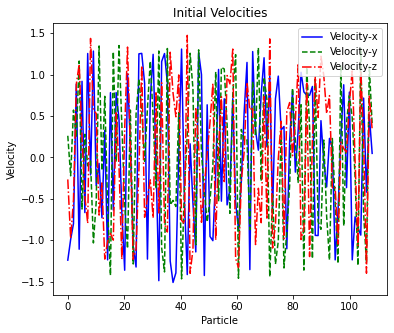

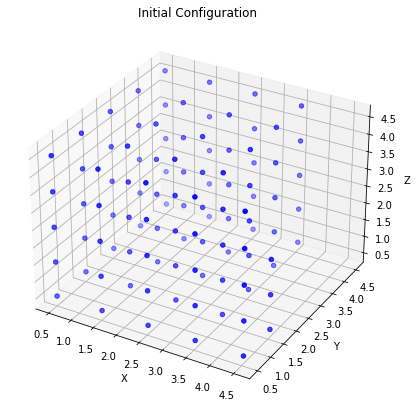

In [3]:
# system parameters
N = 108
T = 0.728
rho = 0.8442
L = np.cbrt(N/rho)

# initialize system
posi, vel = initialize(N, L, T)

# system momentum in x, y, and z directions
momentumx = np.sum(vel[0,:])
momentumy = np.sum(vel[1,:])
momentumz = np.sum(vel[2,:])

print("System's momentum in x-direction: %.4f"%momentumx)
print("System's momentum in y-direction: %.4f"%momentumy)
print("System's momentum in z-direction: %.4f"%momentumz)

# kinetic energy
kin1 = 1.5*T
kin2 = 0.0
for i in range(N):
    kin2 = kin2 + 0.5*np.sum(vel[:,i]**2)
print("Kinetic energy per particle from system's temperature: %.4f"%kin1)
print("Kinetic energy per particle from velocities: %.4f"%(kin2/float(N)))

# plot velocities
pr = np.linspace(0, N, N)
plt.figure(figsize=[6,5])
plt.plot(pr, vel[0,:], color = 'blue', linestyle = 'solid', label = 'Velocity-x')
plt.plot(pr, vel[1,:], color = 'green', linestyle = 'dashed',  label = 'Velocity-y')
plt.plot(pr, vel[2,:], color = 'red', linestyle = 'dashdot',  label = 'Velocity-z')
plt.xlabel('Particle')
plt.ylabel('Velocity')
plt.title('Initial Velocities')
plt.legend()
plt.show()

# show initial configuration
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(posi[0,:], posi[1,:], posi[2,:], color = 'blue')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Initial Configuration')
plt.show()

# PART 2: LENARD-JONES FORCE

In [4]:
def LJ_Force(pos, N, L):
    """
    Calculates Lenard-Jones force and potential energy
    
    Input Parameters:
    -----------------
    pos:        position vector of all particles
    N:          number of particles
    L:          length of primitive cube
    
    Output Parameters
    -----------------
    f:          forces acting on particles
    Epot:       system's total potential energy
    
    """
    # initialize forces
    f = np.zeros([3,N])
    # re-assign positions
    post = np.copy(pos)
    # initialize system potential energy
    Epot = 0.0
    for i in range(0,N-1):
        for j in range(i+1, N):
            # compute distance between the two particles
            r = np.copy(post[:,i]) - np.copy(post[:,j])
            # apply minimum image correction
            for k in range(len(r)):
                if(r[k] >= 0.5*L):
                    r[k] = r[k] - L
                elif(r[k] < -0.5*L):
                    r[k] = r[k] + L
            # calculate squared distance
            r2 = np.sum(r**2)
            # inverse of r^2
            r2i = 1.0/r2
            # inverse of r^6
            r6i = r2i**3
            # calculate force
            ff = 48.0*r2i*r6i*(r6i - 0.5)
            # calculate and accumulate force components
            f[:,i] = f[:,i] + ff*r
            f[:,j] = f[:,j] - ff*r
            # calculate and accumulate potential energy
            Epot = Epot + 4.0*r6i*(r6i - 1.0)
    return f, Epot

# PART 3: VELOCITY VERLET ALGORITHM

In [5]:
def velocity_verlet(N, L, T, tsteps, dt, posi, vi, freq):
    """
    Performs molecular dynamics simulation using velocity Verlet algorithm
    
    Input Parameters
    ----------------
    N:          number of particles
    L:          length of primitive cube
    T:          reduced temperature
    tsteps:     number of time steps
    dt:         time step size
    posi:       initial position
    vi:         initial velocities
    freq:       sampling frequency
    
    Output Parameters
    -----------------
    stp:          sampled steps
    positions:    positions
    velocities:   velocities
    kinE:         kinetic energy per particle
    PotE:         potential energy per particle
    Etot:         total energy per particle
    """
    # re-assign initial positions and velocities
    pos = np.copy(posi)
    vel = np.copy(vi)
    # calculate initial kinetic energy
    Ekin = 0.0
    for i in range(0, N):
        Ekin = Ekin + 0.5*np.sum(vel[:,i]**2)
    # initialize output parameters
    Nsamps = int(round(tsteps/freq))
    stp = np.zeros(Nsamps)
    positions = np.zeros([Nsamps, 3, N])
    velocities = np.zeros([Nsamps, 3, N])
    kinE = np.zeros(Nsamps)
    PotE = np.zeros(Nsamps)
    Etot = np.zeros(Nsamps)
    # intialize time
    t = 0
    # calculate forces at time 't'
    fi, Epot = LJ_Force(np.copy(pos), N, L)
    m = 0
    for i in range(0, tsteps):
        # sample outputs
        if(i%freq == 0):
            stp[m] = i
            positions[m,:,:] = np.copy(pos)
            velocities[m, :, :] = np.copy(vel)
            kinE[m] = Ekin/float(N)
            PotE[m] = Epot/float(N)
            Etot[m] = (Ekin + Epot)/float(N)
            m = m + 1
        # calculate new positions at time 't + dt'
        for j in range(0, len(pos[0,:])):
            # update position
            posv = np.copy(pos[:,j]) + dt*np.copy(vel[:,j]) + 0.5*(dt**2)*np.copy(fi[:,j])
            # apply periodic boundary condition
            pos[:, j] = np.mod(np.copy(posv), L)
        # calculate new forces at time 't + dt'
        fii, Epot = LJ_Force(np.copy(pos), N, L)
        # calculate new velocities at time 't + dt'
        Ekin = 0.0
        for k in range(0, len(vel[0,:])):
            # update velocity components
            vel[:,k] = np.copy(vel[:,k]) + 0.5*dt*(np.copy(fi[:,k]) + np.copy(fii[:,k]))
            # calculate and accumulate kinetic energy
            Ekin = Ekin + 0.5*np.sum(np.copy(vel[:,k])**2)
        # update forces at time 't'
        fi = np.copy(fii)
        # update time
        t  = t + dt
    return stp, positions, velocities, kinE, PotE, Etot

# PART 4A: EQUILIBRATION

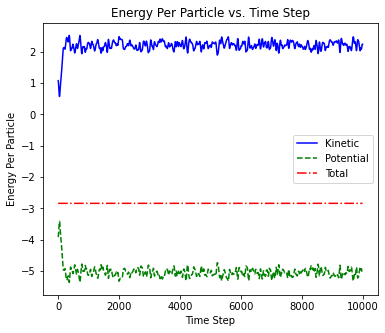

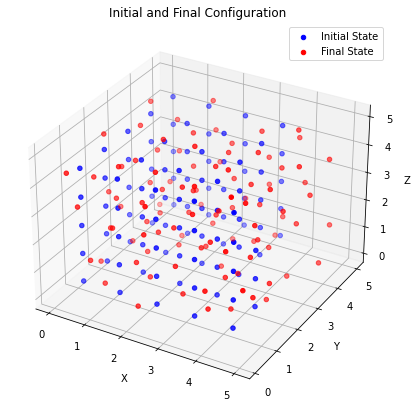

Wall time: 17min 7s


In [6]:
%%time
# simulation and configurational parameters
N = 108                           # number of particles
T = 0.728                         # reduced temperature
rho = 0.8442                      # reduced density
L = np.cbrt(N/rho)                # reduced length of primitive cube
dt = 0.001                        # time step (2 femto-seconds for Argon)
steps = 10000                     # number of time steps (total time of 20 pico-seconds)
freq = 1                          # sampling frequency

# initialize positions and velocities
posi, veli = initialize(N, L, T)

# run MD to equilibrate system
tii, posii, vei, Eki, Epi, Eti = velocity_verlet(N, L, T, steps, dt, posi, veli, freq)

# plot kinetic, potential and total energy
plt.figure(figsize=[6,5])
plt.plot(tii, Eki, color = 'blue', linestyle = 'solid', label = 'Kinetic')
plt.plot(tii, Epi, color = 'green', linestyle = 'dashed', label = 'Potential')
plt.plot(tii, Eti, color = 'red', linestyle = 'dashdot', label = 'Total')
plt.xlabel('Time Step')
plt.ylabel('Energy Per Particle')
plt.title('Energy Per Particle vs. Time Step')
plt.legend()
plt.show()

# show initial and final configuration
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(posii[0, 0,:], posii[0, 1,:], posii[0, 2,:], color = 'blue', label = 'Initial State')
ax.scatter3D(posii[-1, 0,:], posii[-1, 1,:], posii[-1, 2,:], color = 'red', label = 'Final State')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Initial and Final Configuration')
plt.legend()
plt.show()

# PART 4B: SELF DIFUSSION COEFFICIENT

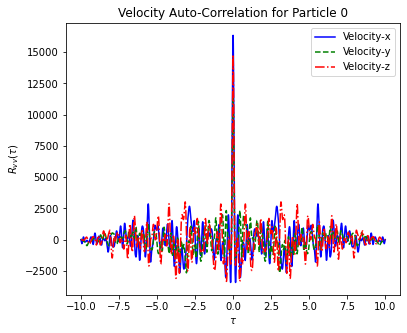

Self diffusion coefficient in reduced units: 744.5259
Self diffusion coefficient in SI units: 4.0282e-06 m²/s
Wall time: 16min 56s


In [7]:
%%time
# simulation and configurational parameters
N = 108                                                  # number of particles
T = 0.728                                                # reduced temperature
rho = 0.8442                                             # reduced density
L = np.cbrt(N/rho)                                       # reduced length of primitive cube
dt = 0.001                                               # time step (~2 femto-seconds for Argon)
steps = 10000                                            # number of time steps 
m_argon = 0.039948/Nav                                   # mass of Argon in kg per particle
sigma = 3.345e-10                                        # equilibrium bond length in metres
epsilon = 125.7*KB                                       # energy at equilibrium bond length
t_tot =  (dt*steps*sigma*np.sqrt(m_argon/epsilon))       # total simulation time in SI units (~20 picoseconds)
freq = 1                                                 # sampling frequency

# Run MD with equilibrated positions and velocities obtained in Part 4A
ti, posf, ve, Ek, Ep, Et = velocity_verlet(N, L, T, steps, dt, posii[-1,:,:], vei[-1,:,:], freq)

# compute time lags and velocity auto-correlation functions for particle 0
lag = dt * np.linspace(-steps, steps, 2*steps-1)
vacfx = np.correlate(ve[:, 0, 0], ve[:, 0, 0], mode = 'full')
vacfy = np.correlate(ve[:, 1, 0], ve[:, 1, 0], mode = 'full')
vacfz = np.correlate(ve[:, 2, 0], ve[:, 2, 0], mode = 'full')

# plot velocity auto-correlation function for particle 0
plt.figure(figsize=[6,5])
plt.plot(lag, vacfx, color = 'blue', linestyle = 'solid', label = 'Velocity-x')
plt.plot(lag, vacfy, color = 'green', linestyle = 'dashed', label = 'Velocity-y')
plt.plot(lag, vacfz, color = 'red', linestyle = 'dashdot', label = 'Velocity-z')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R_{vv} (\tau)$')
plt.title('Velocity Auto-Correlation for Particle 0')
plt.legend()
plt.show()

# compute self-diffusion coefficient using Green-Kubo relation; value obtained in reduced units;
DPCB = 0.0
for i in range(0, N):
    for j in range(0, 3):
        # compute auto-correlation function
        vacf = np.correlate(ve[:, j, i], ve[:, j, i], mode = 'full')
        # integrate auto-correlation function with respect to time lag; accumulate value
        DPCB = DPCB + integrate.simps(vacf[-steps:], dx=dt)
# Divide DPCB by number of particles and dimensions to obtain self-diffusion coefficient
DPCB = DPCB/(3.0*float(N))
# Convert diffusion coefficient to SI units
DPCBA = DPCB*(sigma**2)/t_tot
# Display both reduced and actual diffusion coefficient
print('Self diffusion coefficient in reduced units: %.4f'%DPCB)
print("Self diffusion coefficient in SI units: {:.4e} m\u00b2/s".format(DPCBA))

# PART 5: NVE MOLECULAR DYNAMICS

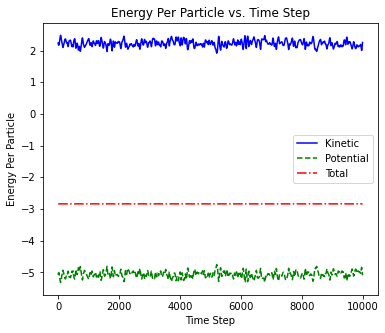

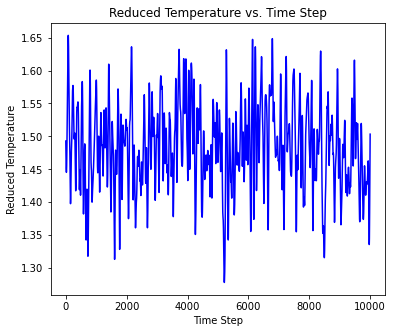

Wall time: 16min 56s


In [8]:
%%time
# simulation and configurational parameters
N = 108                           # number of particles
T = 0.728                         # reduced temperature
rho = 0.8442                      # reduced density
L = np.cbrt(N/rho)                # reduced length of primitive cube
dt = 0.001                        # time step (2 femto-seconds for Argon)
steps = 10000                     # number of time steps (total time of 20 pico-seconds)
freq = 1                          # sampling frequency

# Run NVE MD with final positions and velocities from part 4B
# The required plots could also be generated from the results in PART B without necessarily running another MD simulation
ti2, posf2, ve2, Ek2, Ep2, Et2 = velocity_verlet(N, L, T, steps, dt, posf[-1,:,:], ve[-1,:,:], freq)

# plot kinetic, potential and total energy
plt.figure(figsize=[6,5])
plt.plot(ti2, Ek2, color = 'blue', linestyle = 'solid', label = 'Kinetic')
plt.plot(ti2, Ep2, color = 'green', linestyle = 'dashed', label = 'Potential')
plt.plot(ti2, Et2, color = 'red', linestyle = 'dashdot', label = 'Total')
plt.xlabel('Time Step')
plt.ylabel('Energy Per Particle')
plt.title('Energy Per Particle vs. Time Step')
plt.legend()
plt.show()

# compute and plot temperature
Ts = (2.0/3.0)*Ek2
plt.figure(figsize = [6,5])
plt.plot(ti2, Ts, color = 'blue')
plt.xlabel('Time Step')
plt.ylabel('Reduced Temperature')
plt.title('Reduced Temperature vs. Time Step')
plt.show()

---
---

# CONCLUDING REMARKS

 - The velocity auto-correlation function plotted in part 4B exhibits a very pronounced peak at zero lag, which makes sense since the two velocities are exactly identical. The velocity auto-correlation function then decays with increasing/decreasing lag, suggesting lower correlation as simulation progresses. This also implies that after sufficiently long time, the velocities of the particles will be independent of their initial randomly assigned values.
 
 - Both kinetic and potential energy in part 4A reach equilibrium rather quickly. Both then fluctuate about some mean values. The total energy shows no fluctuations since it is being conserved.
 
 - In part 5, the particles start from equilibrium positions and velocities obtained in part 4B, and so the kinetic and potential energy fluctuate about their mean values. Similar to Part 4B, the total energy is constant throughout the simulation.
 
 - The temperature also fluctuates and is actually higher than the initial temperature since energy (and not temperature) is being conserved in the NVE MD. 
 
---
---